<h1><center>2021 BRFSS Data: Part 3</center></h1>


#### About the data:
- The dataset used in this project is the 2021 BRFSS Data.
- The Behavioral Risk Factor Surveillance System (BRFSS) is a collaborative project between all the states in the United States and participating US territories and the Centers for Disease Control and Prevention (CDC).
- It is used to collect prevalence data among adult U.S. residents regarding their risk behaviors and preventive health practices that can affect their health status. Respondent data are forwarded to CDC to be aggregated for each state, returned with standard tabulations, and published at year's end by each state. 
- To get the database used, __[Click Here](https://www.cdc.gov/brfss/annual_data/annual_2021.html)__
- For the codebook of the database, __[Click Here](https://www.cdc.gov/brfss/annual_data/2021/pdf/codebook21_llcp-v2-508.pdf)__


#### The project is:
- __Part 1. Preparing:__ In this part, I will choose what columns will be left to analyze, change the values in them to more human-readable form according to the BRFSS codebook.<br>
- __Part 2. EDA:__ In this part, I will do some exploratory data analysis, trying to find insights from the data.<br>
- __Part 3. Statistics:__ In this part, I will do some statistical hypotheses testing to evaluate some of the insights found in part 2, I will also conduct regression analysis.

In [1]:
# Import the packages that will be needed in this analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score

import warnings
warnings.filterwarnings('ignore')


# Define some setting
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams['axes.titlesize'] = 18

In [2]:
df = pd.read_csv('LLCP2021_Prepared.csv')
df.sample(5)

,Urban_Rural,Gender,Age_Category,Education,Martial_Status,Income_Category,Veteran,Height,Weight,BMI,BMI_Category,Smoking,Alcohol_Drinks,Insurance,HTN,MI,CHD,Stroke,DM,DM_Age,BGM_Weekly,A1C,Insulin,Retinopathy_Counseled,Feet_Check,Asthma,COPD,Arthritis,Kidney_Disease,Depression
315506,Urban counties,Female,25 to 34,Graduated High School,NaN,"$25,000 to < $35,000",No,160.0,NaN,NaN,NaN,Never smoked,NaN,NaN,No,No,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,No,No,No,No,No
178963,Urban counties,Male,55 to 64,Attended College or Technical School,Married,"$25,000 to < $35,000",No,173.0,113.4,38.01,Obese,Former smoker,2.0,Yes,Yes,Yes,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,No,Yes,Yes,No,No
38033,Urban counties,Male,25 to 34,Graduated from College or Technical School,Never married,"$50,000 to < $100,000",No,188.0,63.5,17.97,Underweight,Current smoker,3.0,Yes,No,No,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,No,No,No,No,Yes
93266,Rural counties,Female,65 or older,Graduated High School,Married,"$25,000 to < $35,000",No,NaN,NaN,NaN,NaN,Never smoked,NaN,Yes,Yes,No,Yes,No,No,NaN,NaN,NaN,NaN,NaN,NaN,No,No,No,No,No
195759,Urban counties,Female,25 to 34,Graduated from College or Technical School,Never married,"$50,000 to < $100,000",No,168.0,56.7,20.18,Normal Weight,Never smoked,3.0,Yes,No,No,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,Yes,No,No,No,No


In [3]:
diseases = ['HTN', 'DM', 'Asthma', 'COPD', 'Arthritis', 'Kidney_Disease', 'Depression', 'MI', 'CHD', 'Stroke']
num_vars = [col for col in df.columns if df[col].dtypes != 'O']
cat_vars = [col for col in df.columns if (df[col].dtypes == 'O') & (col not in diseases)]
cat_cols = diseases + cat_vars

In [4]:
# Check if there is any outliers in the database.
# And, if they do exist, replace them with the threshold (either upper or lower limits).

def outliers(dataframe, column):
    """This function takes the name of a dataframe and a column name as an input.
    It checks if the given column contains any outliers in its values.
    If there is indeed outliers, it replaces these outliers with the threshold (either upper or lower limits).
    If there is no outliers in the column, no changes will happen.
    """
    q1 = dataframe[column].quantile(0.25)
    q3 = dataframe[column].quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - (1.5 * iqr)
    upper_limit = q3 + (1.5 * iqr)
    if dataframe[(dataframe[column] > upper_limit) | (dataframe[column] < lower_limit)].any(axis=None):
        dataframe.loc[(dataframe[column] < lower_limit), column] = lower_limit
        dataframe.loc[(dataframe[column] > upper_limit), column] = upper_limit
        print(f"{column} column had outliers; these outliers were replaced with upper/lower limits.")
    else:
        print(f"{column} column did not have and outliers; no changes were made.")
    
for col in num_vars:
    outliers(df, col)
    
df.describe().T

Height column did not have and outliers; no changes were made.
Weight column did not have and outliers; no changes were made.
BMI column did not have and outliers; no changes were made.
Alcohol_Drinks column did not have and outliers; no changes were made.
DM_Age column did not have and outliers; no changes were made.
BGM_Weekly column did not have and outliers; no changes were made.
A1C column did not have and outliers; no changes were made.
Feet_Check column did not have and outliers; no changes were made.


,count,mean,std,min,25%,50%,75%,max
Height,401584.0,170.293140,10.631788,140.500000,163.00,170.00,178.00,200.500
Weight,386935.0,83.009184,20.262220,27.225000,68.04,81.65,95.25,136.065
BMI,380722.0,28.441652,5.966126,12.720000,24.21,27.44,31.87,43.360
Alcohol_Drinks,199971.0,2.080892,1.391714,0.000000,1.00,2.00,3.00,6.000
DM_Age,52592.0,49.699859,14.550590,10.000000,40.00,50.00,60.00,90.000
BGM_Weekly,18486.0,9.783080,8.932008,0.019231,2.00,7.00,14.00,32.000
A1C,20557.0,2.521404,1.632547,0.000000,1.00,2.00,4.00,8.500
Feet_Check,21030.0,1.852544,1.699803,0.000000,1.00,1.00,3.00,6.000


# Hypothesis Testing:

### Random hypotheses testings to spot any statistically significant variables that affects diseases: 

- For numerical columns, the test checks the difference of mean between having being diagnosed with each disease and not being diagnosed.
- For categorical columns, if the values in the categorical column are two, then the test checks the difference of proportions between each variable in patients diagnosed with each disease.
- For both of them, the tests check if the difference are statistically significant, then the results are added in a dataframe called 'p_diseases'.

### Null and Alternative Hypotheses:
- __Null Hypothesis $H_0$:__ There is no difference in the proportions of variables between those who are diagnosed and those who are not.
- __Alternative Hypothesis $H_1$:__ Proportions of variables between those who are diagnosed and those who are not is different.

In [5]:
df_ = df.stack().str.replace(' ', '_').unstack().copy()

p_diseases = pd.DataFrame(columns=['Disease', 'Variable','P_Value','Higher_Effect','Difference','Statistical_Significance','Observations'])

for disease in diseases:

    for col in cat_vars:
        temp = df_.dropna(subset=[disease]).copy()
        values = temp[col].dropna().unique()
        
        if len(values) == 2:
            #Number of patients with each specific variable who have the disease
            n_v0 = temp[(temp[disease] == 'Yes') & (temp[col] == values[0])].shape[0]
            n_v1 = temp[(temp[disease] == 'Yes') & (temp[col] == values[1])].shape[0]
            
            #Total number of people with a specific variable
            total_v0 = temp[temp[col] == values[0]].shape[0] 
            total_v1 = temp[temp[col] == values[1]].shape[0]
            pvalue = sm.stats.proportions_ztest([n_v0, n_v1], [total_v0, total_v1], alternative='two-sided')[1]
            
            if pvalue <= 0.05:
                if (n_v0/total_v0) > (n_v1/total_v1):
                    higher = str(values[0])
                else:
                    higher = str(values[1])
                diff = (max((n_v0/total_v0), (n_v1/total_v1)) - min((n_v0/total_v0), (n_v1/total_v1))) * 100
                p_diseases.loc[len(p_diseases.index)] = [str(disease), str(col), pvalue, higher, round(diff, 2), 'Yes', len(temp)]
            else:
                p_diseases.loc[len(p_diseases.index)] = [str(disease), str(col), pvalue, np.nan, np.nan, 'No', len(temp)]

    for col in num_vars:
        temp = df[[disease, col]].dropna(subset=[disease]).copy()
        temp[col] = temp[col].fillna(temp[col].mean())
        if len(temp[disease].unique()) == 2:
            pvalue = sm.stats.ztest(temp[temp[disease] == 'No'][col], temp[temp[disease] == 'Yes'][col], alternative = 'two-sided')[1]

            if pvalue <= 0.05:
                if temp[temp[disease] == 'No'][col].mean() > temp[temp[disease] == 'Yes'][col].mean():
                    higher = 'No'
                else:
                    higher = 'Yes'
                diff = max(temp[temp[disease] == 'No'][col].mean(), temp[temp[disease] == 'Yes'][col].mean()) - min(temp[temp[disease] == 'No'][col].mean(), temp[temp[disease] == 'Yes'][col].mean()) 
                p_diseases.loc[len(p_diseases.index)] = [str(disease), str(col), pvalue, higher, round(diff, 2), 'Yes', len(temp)]
            else:
                p_diseases.loc[len(p_diseases.index)] = [str(disease), str(col), pvalue, np.nan, np.nan, 'No', len(temp)]

p_diseases = p_diseases.sort_values(by=['Statistical_Significance', 'Disease']).reset_index(drop=True)

print(f"Total number of {len(p_diseases)} hypothesis testings were conducted.\n\
{len(p_diseases[p_diseases['Statistical_Significance'] == 'Yes'])} of them proved statistical significance, \
and {len(p_diseases[p_diseases['Statistical_Significance'] == 'No'])} showed no statistical significance.")

p_diseases

Total number of 140 hypothesis testings were conducted.
131 of them proved statistical significance, and 9 showed no statistical significance.


,Disease,Variable,P_Value,Higher_Effect,Difference,Statistical_Significance,Observations
0,Arthritis,Retinopathy_Counseled,1.537012e-01,NaN,NaN,No,416248
1,Asthma,Alcohol_Drinks,9.006818e-01,NaN,NaN,No,417393
2,DM,Insulin,NaN,NaN,NaN,No,418154
3,DM,Retinopathy_Counseled,NaN,NaN,NaN,No,418154
4,DM,DM_Age,1.000000e+00,NaN,NaN,No,418154
5,DM,BGM_Weekly,1.000000e+00,NaN,NaN,No,418154
6,DM,A1C,1.000000e+00,NaN,NaN,No,418154
7,DM,Feet_Check,1.000000e+00,NaN,NaN,No,418154
8,Kidney_Disease,Urban_Rural,1.346588e-01,NaN,NaN,No,417328
9,Arthritis,Urban_Rural,1.025815e-142,Rural_counties,5.29,Yes,416248


- __The main findings from the conducted tests above are:__
    - Results that had statistically significant difference:
        - Diabetic patients who also suffer from cardiovascular complications or kidney diseases have higher probability of checking for retinopathy than those who are not.
        - Diabetic patients who also suffer from cardiovascular complications or kidney diseases have higher probability of taking insulin than those who are not.
        - Veterans are less likely to be diagnosed depression or Asthma, but are more likely to be diagnosed with Arthritis, COPD, Diabetes, Hypertension and cardiovascular complications.
        - Proportion of people living in rural areas who suffer from Asthma or Hypertension is around 5% higher than those who live in urban areas.
        - Proportion of females who are diagnosed with Arthritis, Asthma, & Depression is more than males.
        - Proportion of males who are diagnosed with cardiovascular diseases (HTN, MI, CHD) is more than females.
        - In all diseases in the datasets, patients who were diagnosed had a higher average BMI than those who were not diagnosed.
        - People who are any kind of insurance were more likely to be diagnosed in all the diseases in the dataset. Most probable reason is that those who do not have insurance suffer from those disease but are undiagnosed, which would put them at risk for complications, but more data is needed to confirm this hypothesis. 
        <br><br>
    - Results that did not have statistically significant difference:
        - There is no difference in the average alcohol drinks between those diagnosed with Asthma and those who are not.
        - There is no difference in the proportion of patients having kidney disease between those who live in rural counties and urban counties.

### Random hypotheses testings to spot any statistically significant difference between the numerical and categorical variables: 

- The next tests take each of the numerical variables in the dataset and test it against all the categorical variables (except the diseases columns) and check if there is any difference of the mean of that numerical variable in the two groups of the categorical variable.  
- For both of them, the tests check if the difference are statistically significant, then the results are added in a dataframe called 'p_numerics'.

### Null and Alternative Hypotheses:
- __Null Hypothesis $H_0$:__ There is no difference in the average of the numerical variable in the two groups of the categorical variables.
- __Alternative Hypothesis $H_1$:__ The average of the numerical variable in the two groups of the categorical variables is different.

In [6]:
p_numerics = pd.DataFrame(columns=['Categorical_Variable', 'Numeric_Variable', 'Higher_Effect', 'Difference', 'P_Value','Statistical_Significance'])

for cat in cat_vars:
    for num in num_vars:
        values = df[cat].dropna().unique()
        if len(values) == 2:
            pvalue = sm.stats.ztest(df[df[cat] == values[0]][num].dropna(), df[df[cat] == values[1]][num].dropna(), alternative = 'two-sided')[1]
            if pvalue <= 0.05:
                if df[df[cat] == values[0]][num].dropna().mean() > df[df[cat] == values[1]][num].dropna().mean():
                    higher = str(values[0])
                else:
                    higher = str(values[1])
                diff = max(df[df[cat] == values[0]][num].dropna().mean(), df[df[cat] == values[1]][num].dropna().mean()) - min(df[df[cat] == values[0]][num].dropna().mean(), df[df[cat] == values[1]][num].dropna().mean()) 
                p_numerics.loc[len(p_numerics.index)] = [str(cat), str(num), higher, round(diff, 2), pvalue, 'Yes']
            else:
                p_numerics.loc[len(p_numerics.index)] = [str(cat), str(num), np.nan, np.nan, pvalue, 'No']

p_numerics = p_numerics.sort_values(by=['Statistical_Significance', 'Categorical_Variable'], ascending=[False, True]).reset_index(drop=True)

print(f"Total number of {len(p_numerics)} hypothesis testings were conducted.\n\
{len(p_numerics[p_numerics['Statistical_Significance'] == 'Yes'])} of them proved statistical significance, \
and {len(p_numerics[p_numerics['Statistical_Significance'] == 'No'])} showed no statistical significance.")

p_numerics

Total number of 48 hypothesis testings were conducted.
38 of them proved statistical significance, and 10 showed no statistical significance.


,Categorical_Variable,Numeric_Variable,Higher_Effect,Difference,P_Value,Statistical_Significance
0,Gender,Height,Male,14.78,0.000000e+00,Yes
1,Gender,Weight,Male,14.66,0.000000e+00,Yes
2,Gender,BMI,Male,0.23,3.946987e-32,Yes
3,Gender,Alcohol_Drinks,Male,0.57,0.000000e+00,Yes
4,Gender,DM_Age,Male,0.83,6.004061e-11,Yes
5,Gender,BGM_Weekly,Female,0.68,1.834065e-07,Yes
6,Gender,A1C,Female,0.10,4.451884e-06,Yes
7,Insulin,Height,Yes,0.47,3.342526e-03,Yes
8,Insulin,Weight,Yes,2.62,1.803950e-16,Yes
9,Insulin,BMI,Yes,0.71,6.071964e-14,Yes


- __The main findings from the conducted tests above are:__
    - Results that had statistically significant difference:
        - For diabetic patients, females tend to get diagnosed with Diabetes at lower age compared to men, and their average blood glucose and A1C measurement is higher.
        - Diabetic patients who take insulin for their diabetes usually get diagnosed at lower age than those who do not with an average of 8 years. This is most probably because those who are diagnosed at lower age are type-1 diabetes, but unfortunately, more data is required to prove that hypothesis.
        - Diabetic patients who take insulin on average have higher weight and BMI than those who are not.
        - On average, Diabetic patients who have insurance get diagnosed at age 8 years younger than those who do not have insurance.
        - Veterans tend to be diagnosed with Diabetes at considerably higher age, which could be related to better physical health of veterans.
        <br><br>
    - Results that did not have statistically significant difference:
        - For diabetic patients, average alcoholic drinks are the same between those who take Insulin and those who do not.
        - For diabetic patients, average blood glucose measurement is the same between those who have insurance and those who do not.
        - For diabetic patients, average blood glucose measurement, A1C measurement, feet checking, is the same between those who live in urban areas or rural areas.

### Difference in age of diabetes diagnosis between males and females:

- __Null Hypothesis $H_0$:__ Age of diabetes' diagnosis does not differ between males and females.
- __Alternative Hypothesis $H_1$:__ Females tend to get diagnosed with DM at slightly lower age compared to males.

In [7]:
pvalue = sm.stats.ztest(df[df['Gender'] == 'Female']['DM_Age'].dropna(), df[df['Gender'] == 'Male']['DM_Age'].dropna(), alternative = 'smaller')[1]

if pvalue <= 0.05:
    print(f"The p-value of the conducted hypothesis testing is {pvalue}.\nThis means that the alternative hypothesis is accepted and there is evidence that females do tend to get diagnosed with DM at slightly lower age compared to males.")
else:
    print(f"The p-value of the conducted hypothesis testing is {pvalue}.\nThis means that we fail to reject the null hypothese and there is no statistical evidence that females get diagnosed with DM at slightly lower age compared to males.") 

The p-value of the conducted hypothesis testing is 3.002030553038223e-11.
This means that the alternative hypothesis is accepted and there is evidence that females do tend to get diagnosed with DM at slightly lower age compared to males.


# Logistic Regression Test

In [8]:
# Create a dummy copy of the dataframe

df_dummy = df.copy()

for col in df_dummy.columns:
    if col in num_vars:
        df_dummy[col] = df_dummy[col].fillna(df_dummy[col].mean())
    else:
        if df_dummy[col].dropna().isin(['Yes', 'No']).all() == True:
            df_dummy[col] = df_dummy[col].str.get_dummies()['Yes']
        else:
            df_dummy[df_dummy[col].dropna().unique().tolist()] = pd.get_dummies(df_dummy[col])
            df_dummy.drop([col], axis = 1, inplace=True)

df_dummy.head()

,Veteran,Height,Weight,BMI,Alcohol_Drinks,Insurance,HTN,MI,CHD,Stroke,DM,DM_Age,BGM_Weekly,A1C,Insulin,Retinopathy_Counseled,Feet_Check,Asthma,COPD,Arthritis,Kidney_Disease,Depression,Urban counties,Rural counties,Female,Male,65 or older,55 to 64,45 to 54,18 to 24,25 to 34,35 to 44,Graduated High School,Graduated from College or Technical School,Did not graduate High School,Attended College or Technical School,Married,Widowed,Divorced,Never married,A member of an unmarried couple,Separated,"$25,000 to < $35,000","$15,000 to < $25,000","$50,000 to < $100,000","$35,000 to < $50,000","0 to $15,000","$100,000 to < $200,000","$200,000 or more",Underweight,Overweight,Obese,Normal Weight,Former smoker,Never smoked,Current smoker
0,0,150.0,32.660000,14.540000,2.080892,1,0,0,0,0,0,49.699859,9.78308,2.521404,0,0,1.852544,1,1,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0
1,0,168.0,83.009184,28.441652,2.080892,1,1,0,1,0,1,49.699859,9.78308,2.521404,0,0,1.852544,0,0,1,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,165.0,77.110000,28.290000,2.080892,1,1,0,1,0,1,49.699859,9.78308,2.521404,0,0,1.852544,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1
3,0,163.0,88.450000,33.470000,3.000000,1,1,0,0,0,1,56.000000,9.78308,2.521404,0,0,1.852544,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1
4,0,180.0,93.440000,28.730000,2.080892,1,0,1,0,1,1,65.000000,9.78308,2.521404,0,0,1.852544,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1


In [9]:
df_dummy['intercept'] = 1

y = df_dummy['DM']
x = df_dummy[['intercept', 'BMI', 'Veteran', 'Married']]

lm = sm.Logit(y, x, missing='drop')
fit = lm.fit()
fit.summary2()

Optimization terminated successfully.
         Current function value: 0.379504
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.048      
Dependent Variable: DM               AIC:              318092.5726
Date:               2022-11-19 01:43 BIC:              318136.3559
No. Observations:   419079           Log-Likelihood:   -1.5904e+05
Df Model:           3                LL-Null:          -1.6710e+05
Df Residuals:       419075           LLR p-value:      0.0000     
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     7.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -4.5662    0.0237  -192.7355  0.0000  -4.6126  -4.5198
BMI           0.0908    0.0008   120.3228  0.0000   0.0893   0.0923
Veteran       0.4500    0.0126    35.8137  0.0000   0.4254   0.4746
Married      -0.6787    0.0297   -22.8518  0.0000  -0.7369  -0.6205
==================================================================

"""

In [10]:
print(f"""
The above results mean that:
- With each 1 increase point in BMI, the person is {round(np.exp(0.0923), 1)} times more likely to be diagnosed with Diabetes.
- With married people, Diabetes is {round(np.exp(-0.6620), 1)} times more likely to occur.
""")



The above results mean that:
- With each 1 increase point in BMI, the person is 1.1 times more likely to be diagnosed with Diabetes.
- With married people, Diabetes is 0.5 times more likely to occur.



# Logistic Regression Model

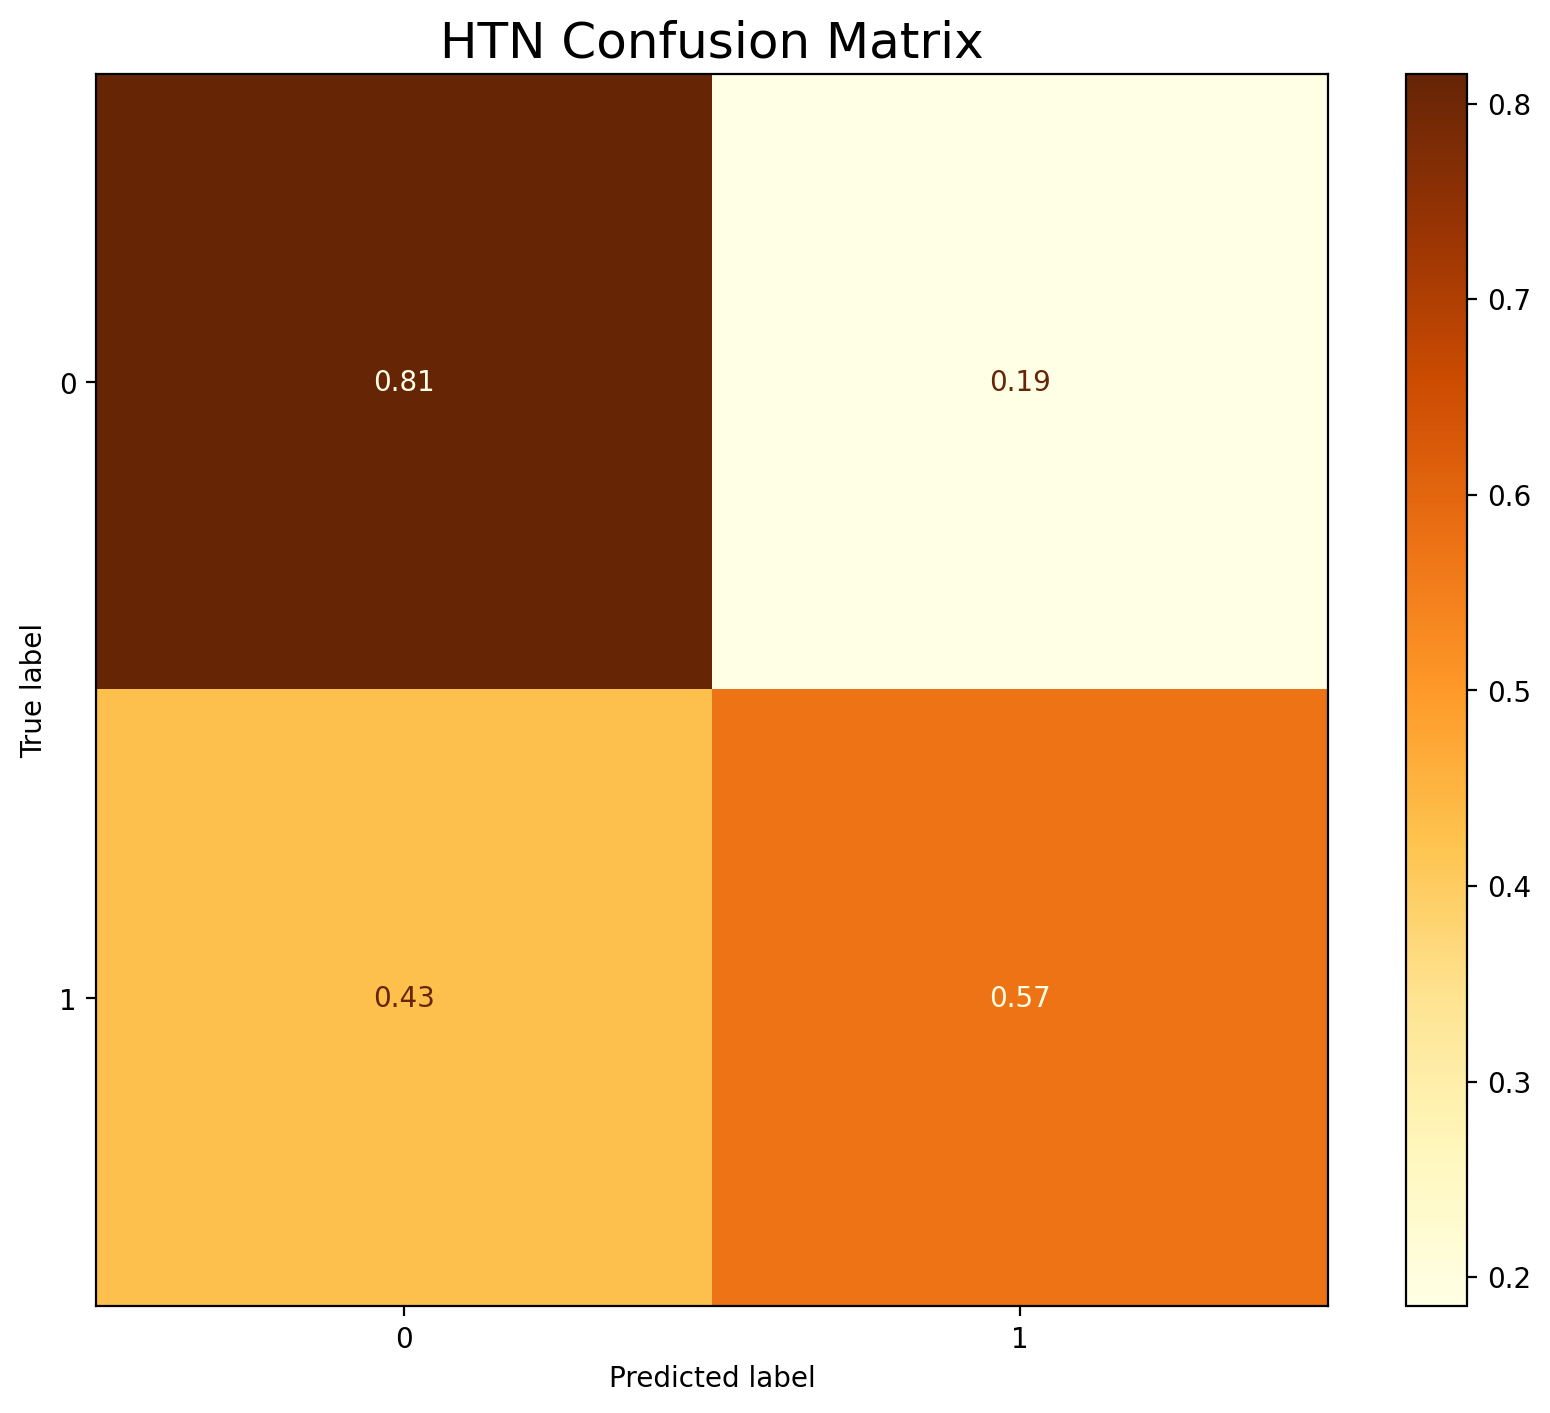

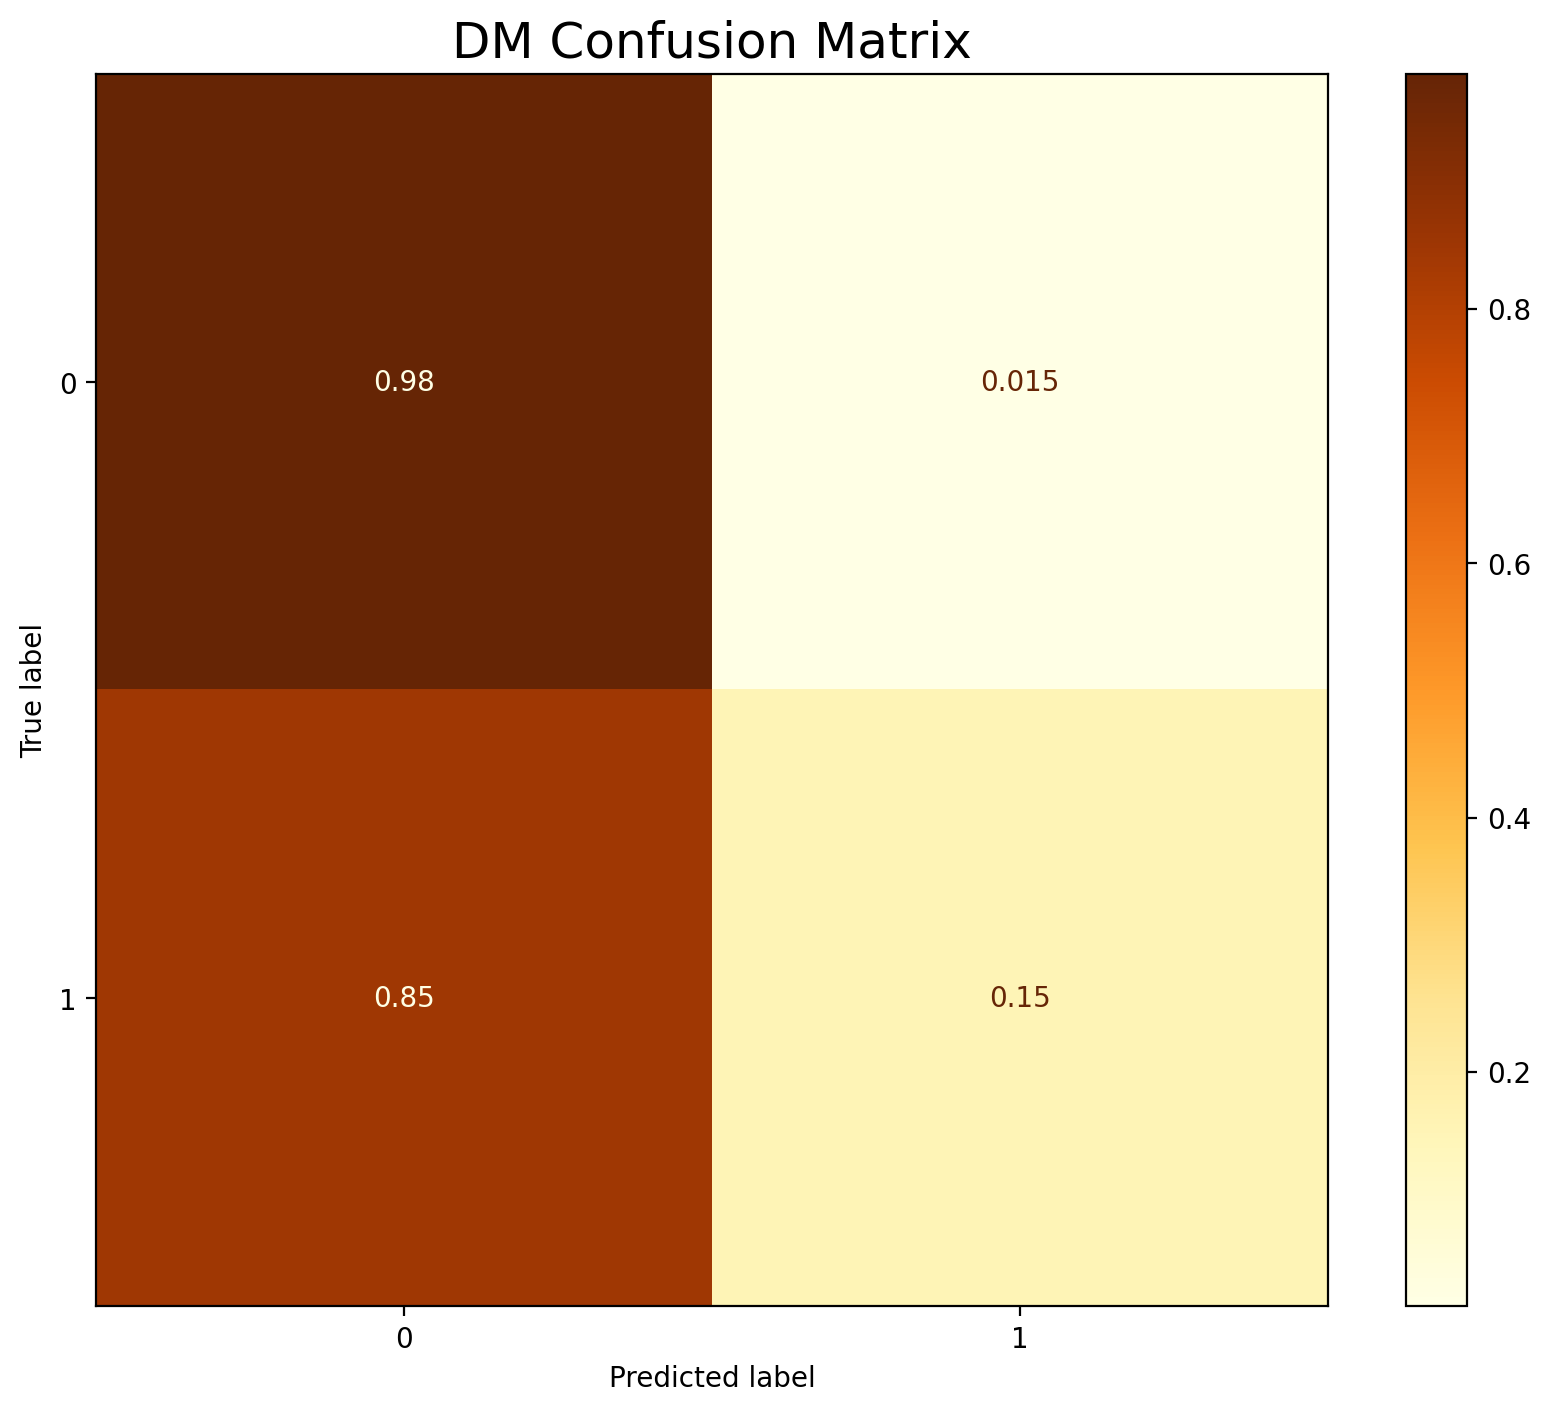

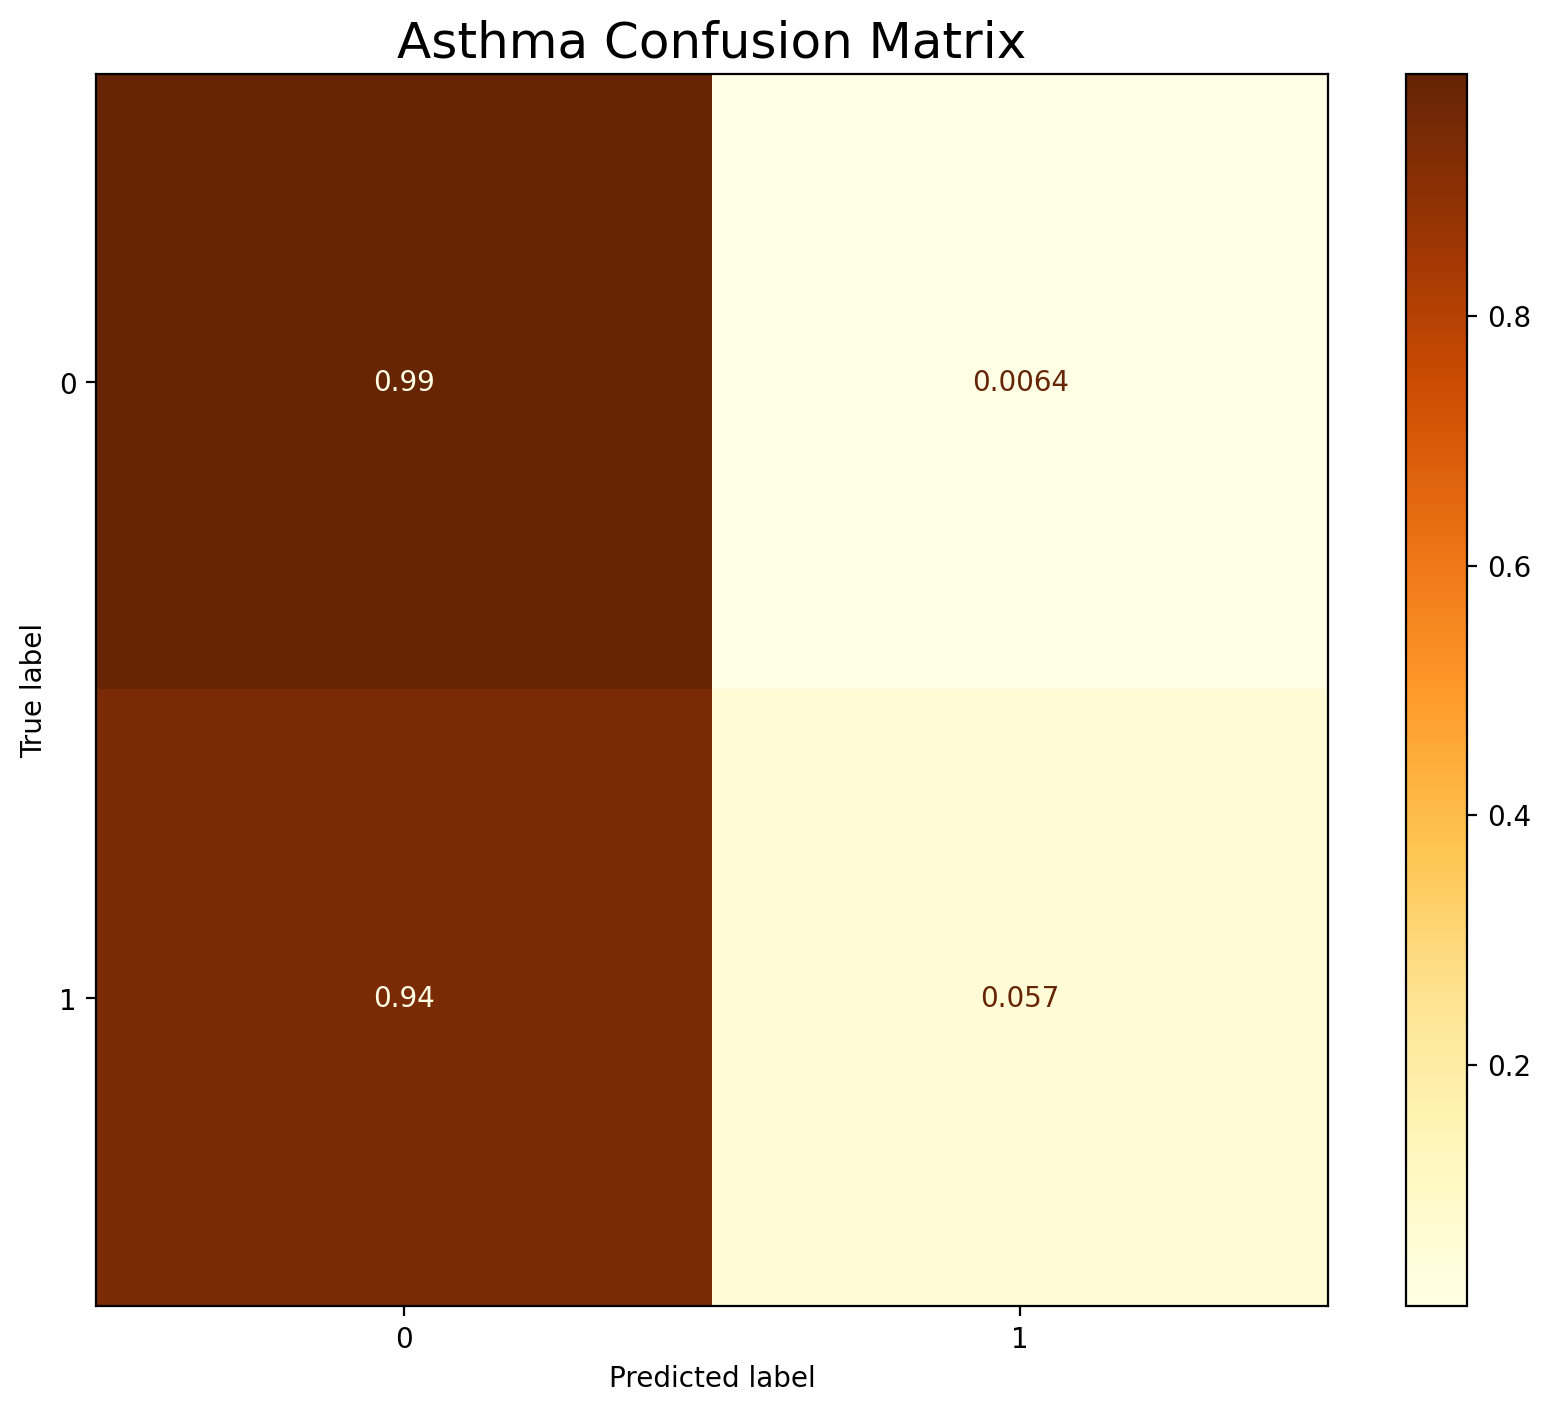

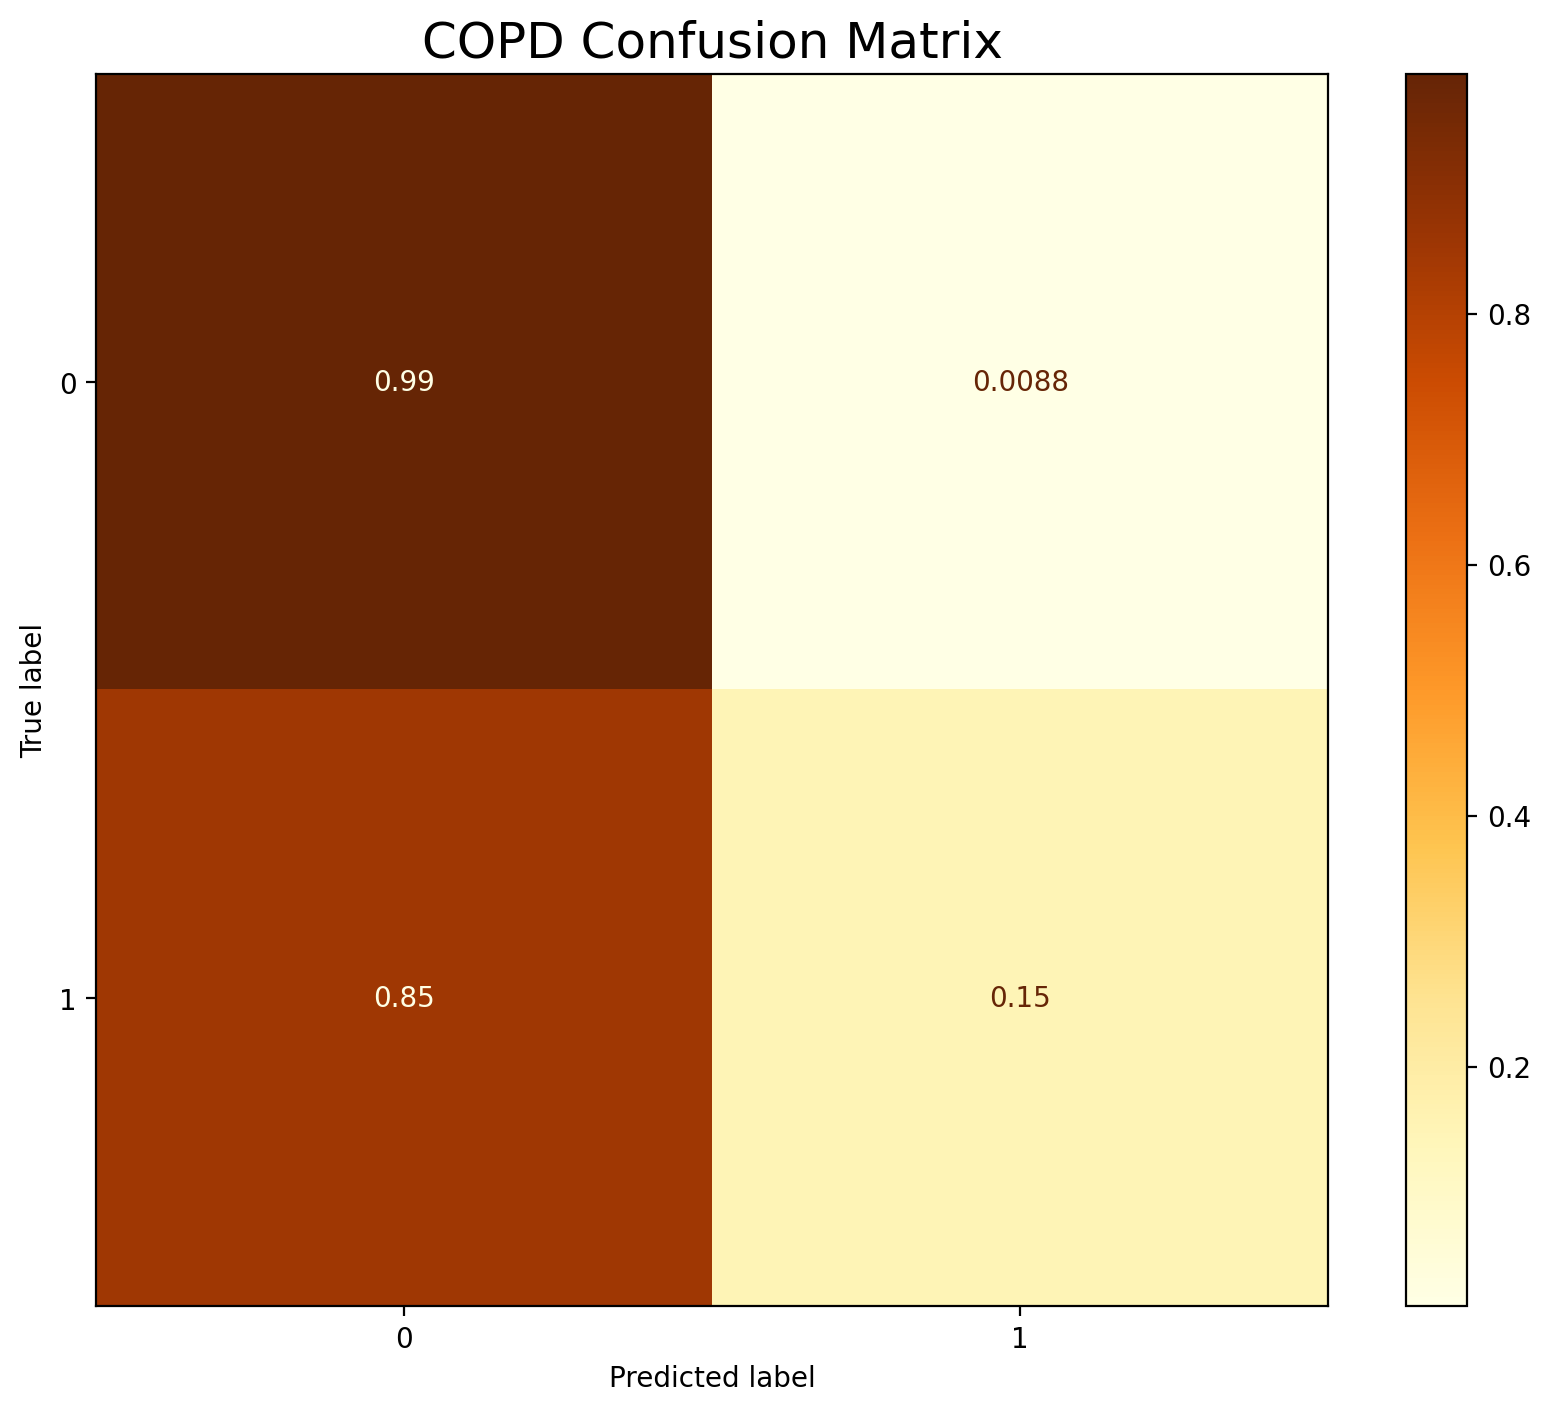

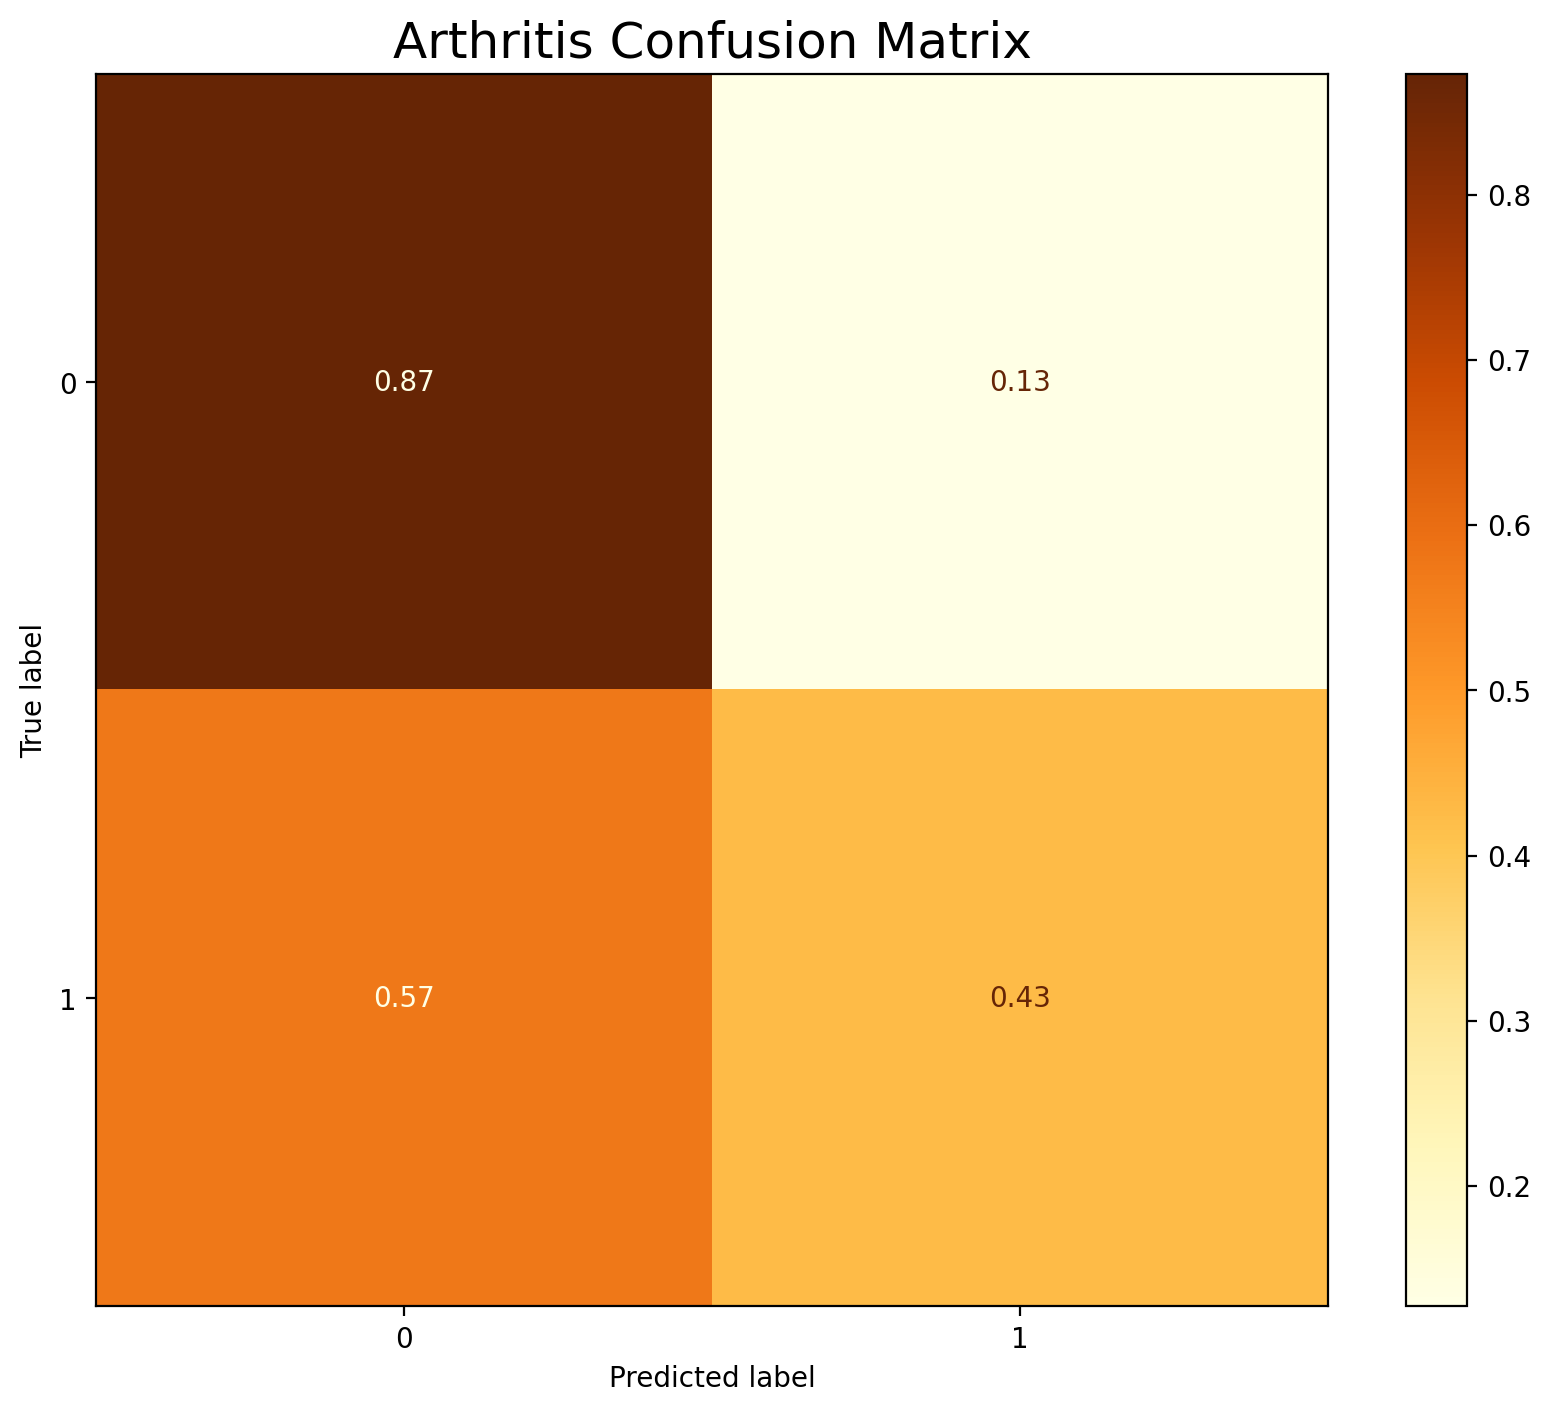

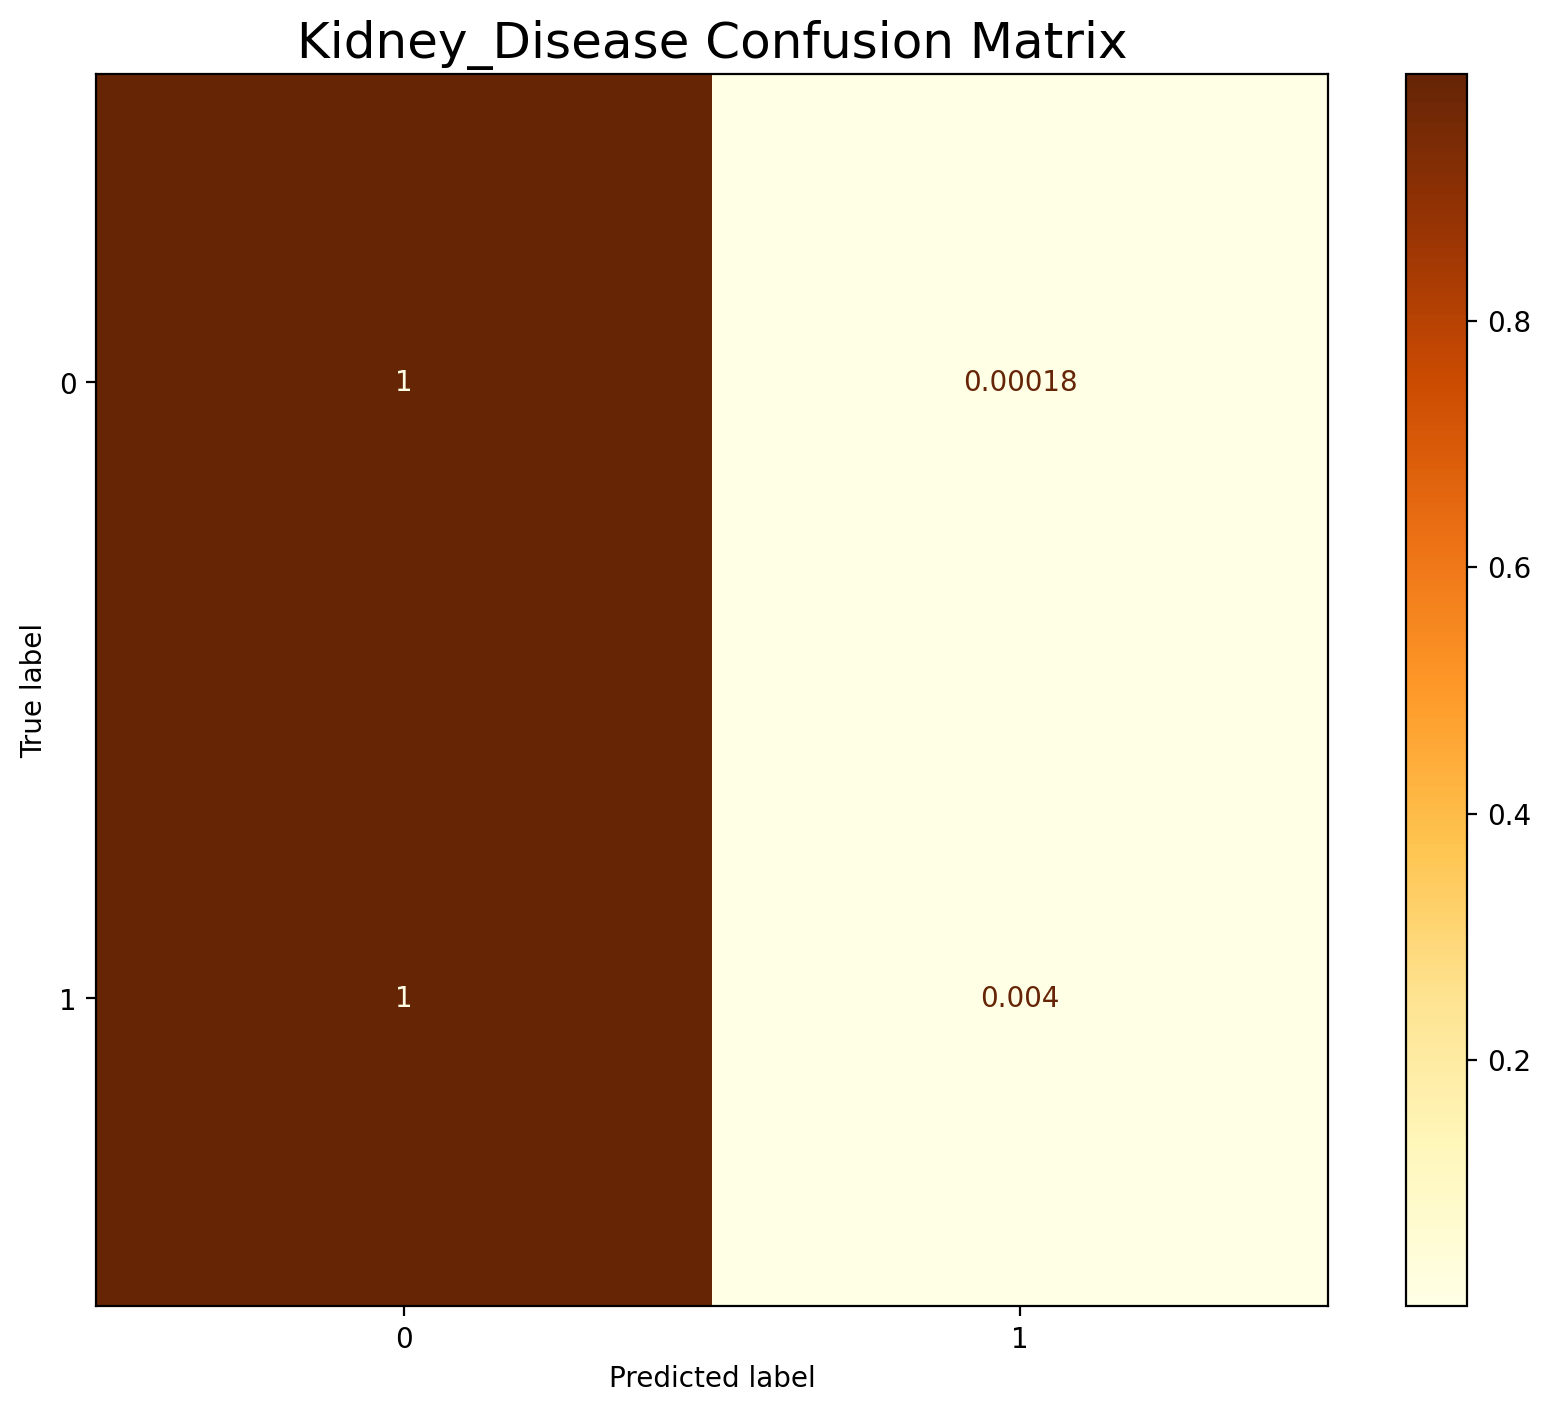

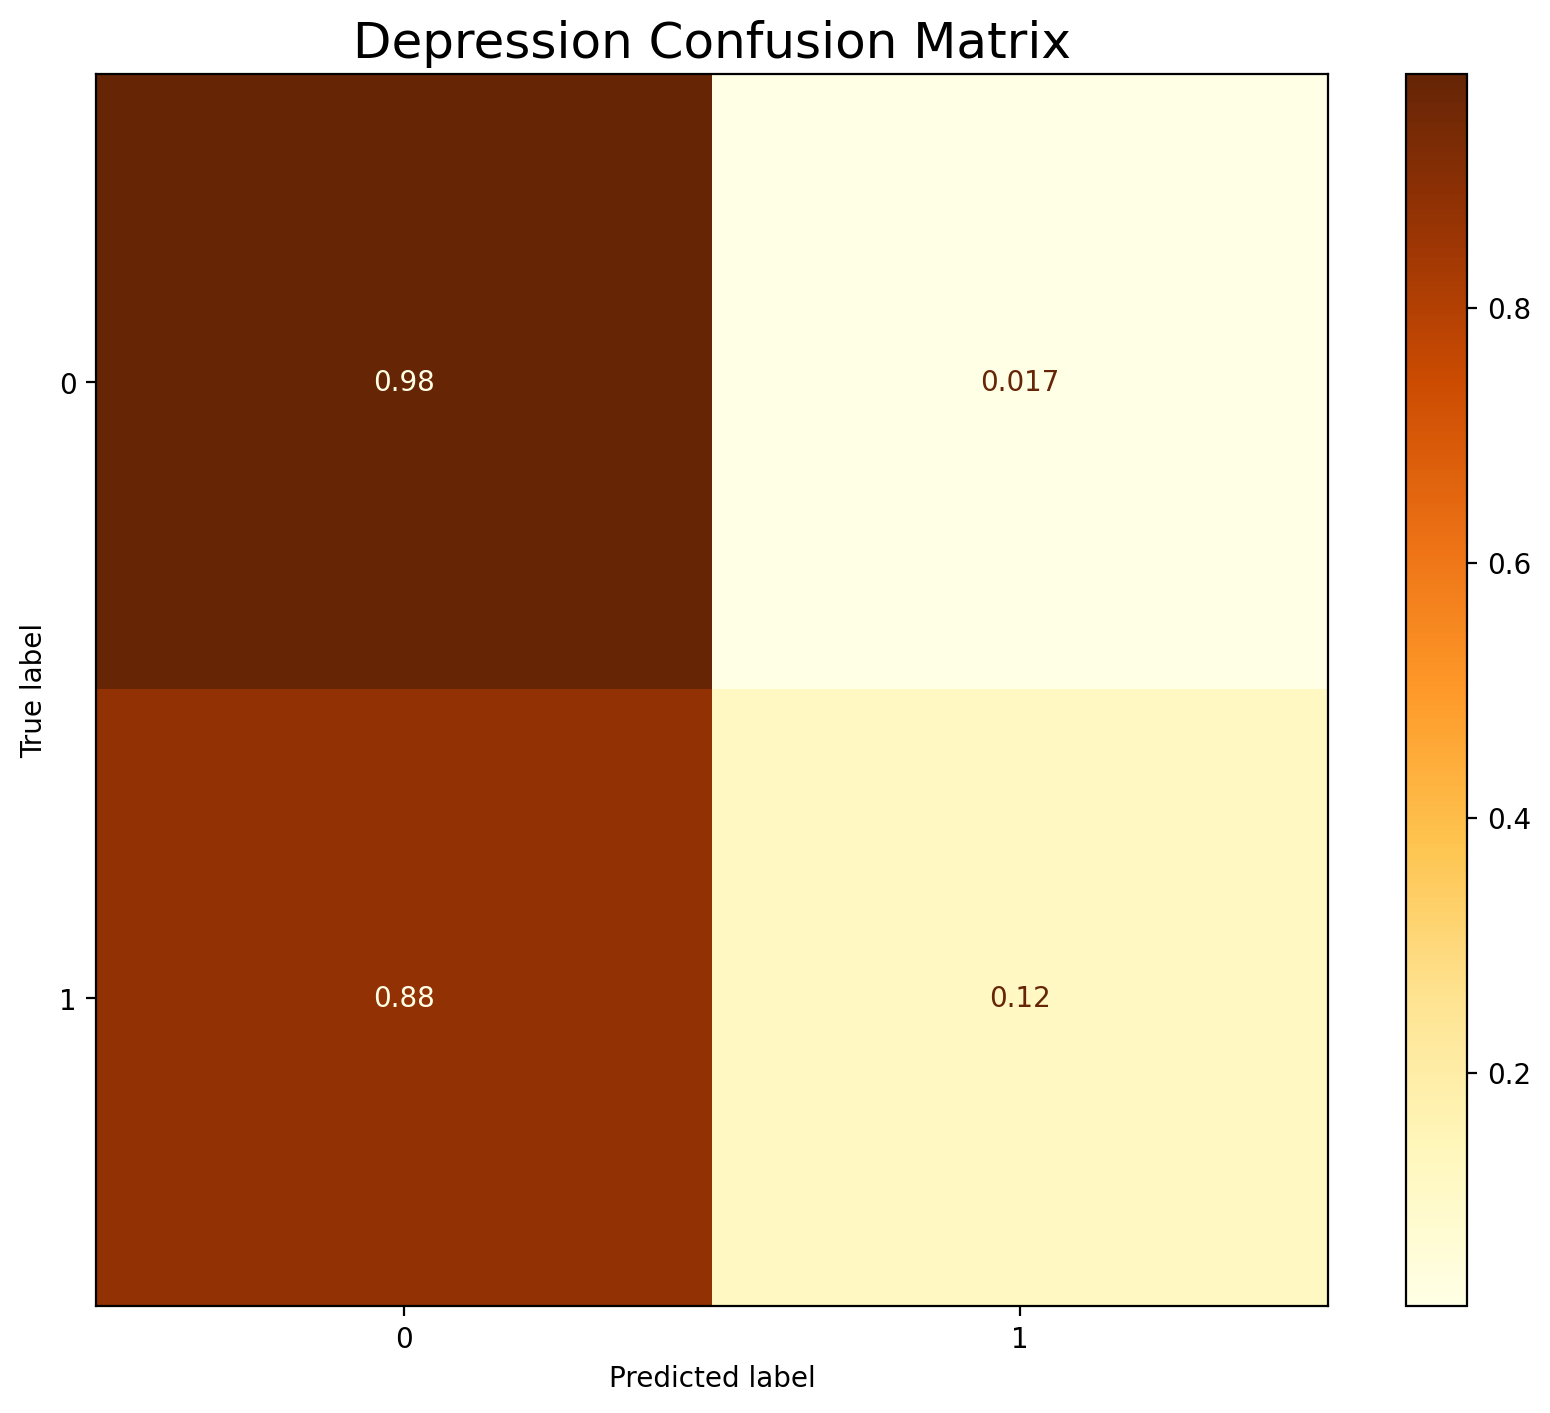

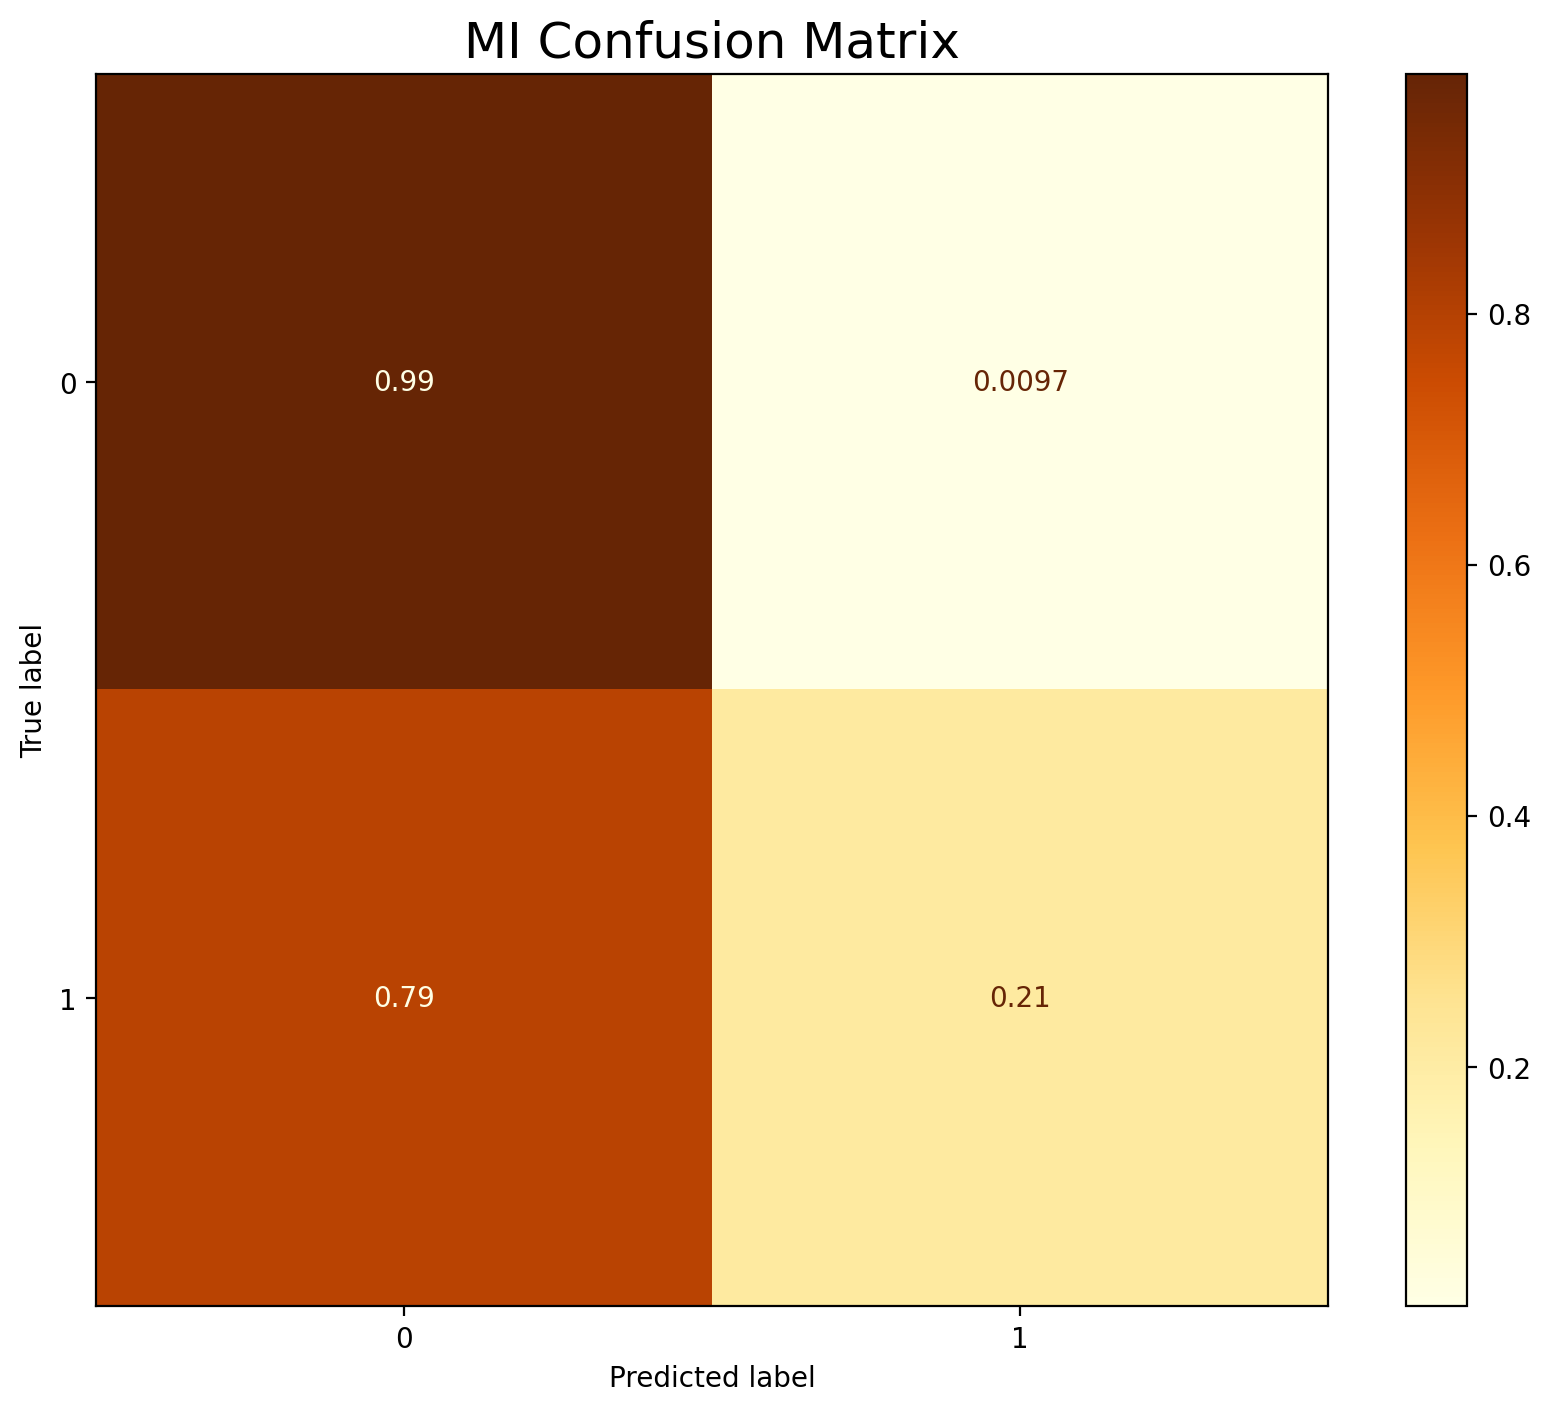

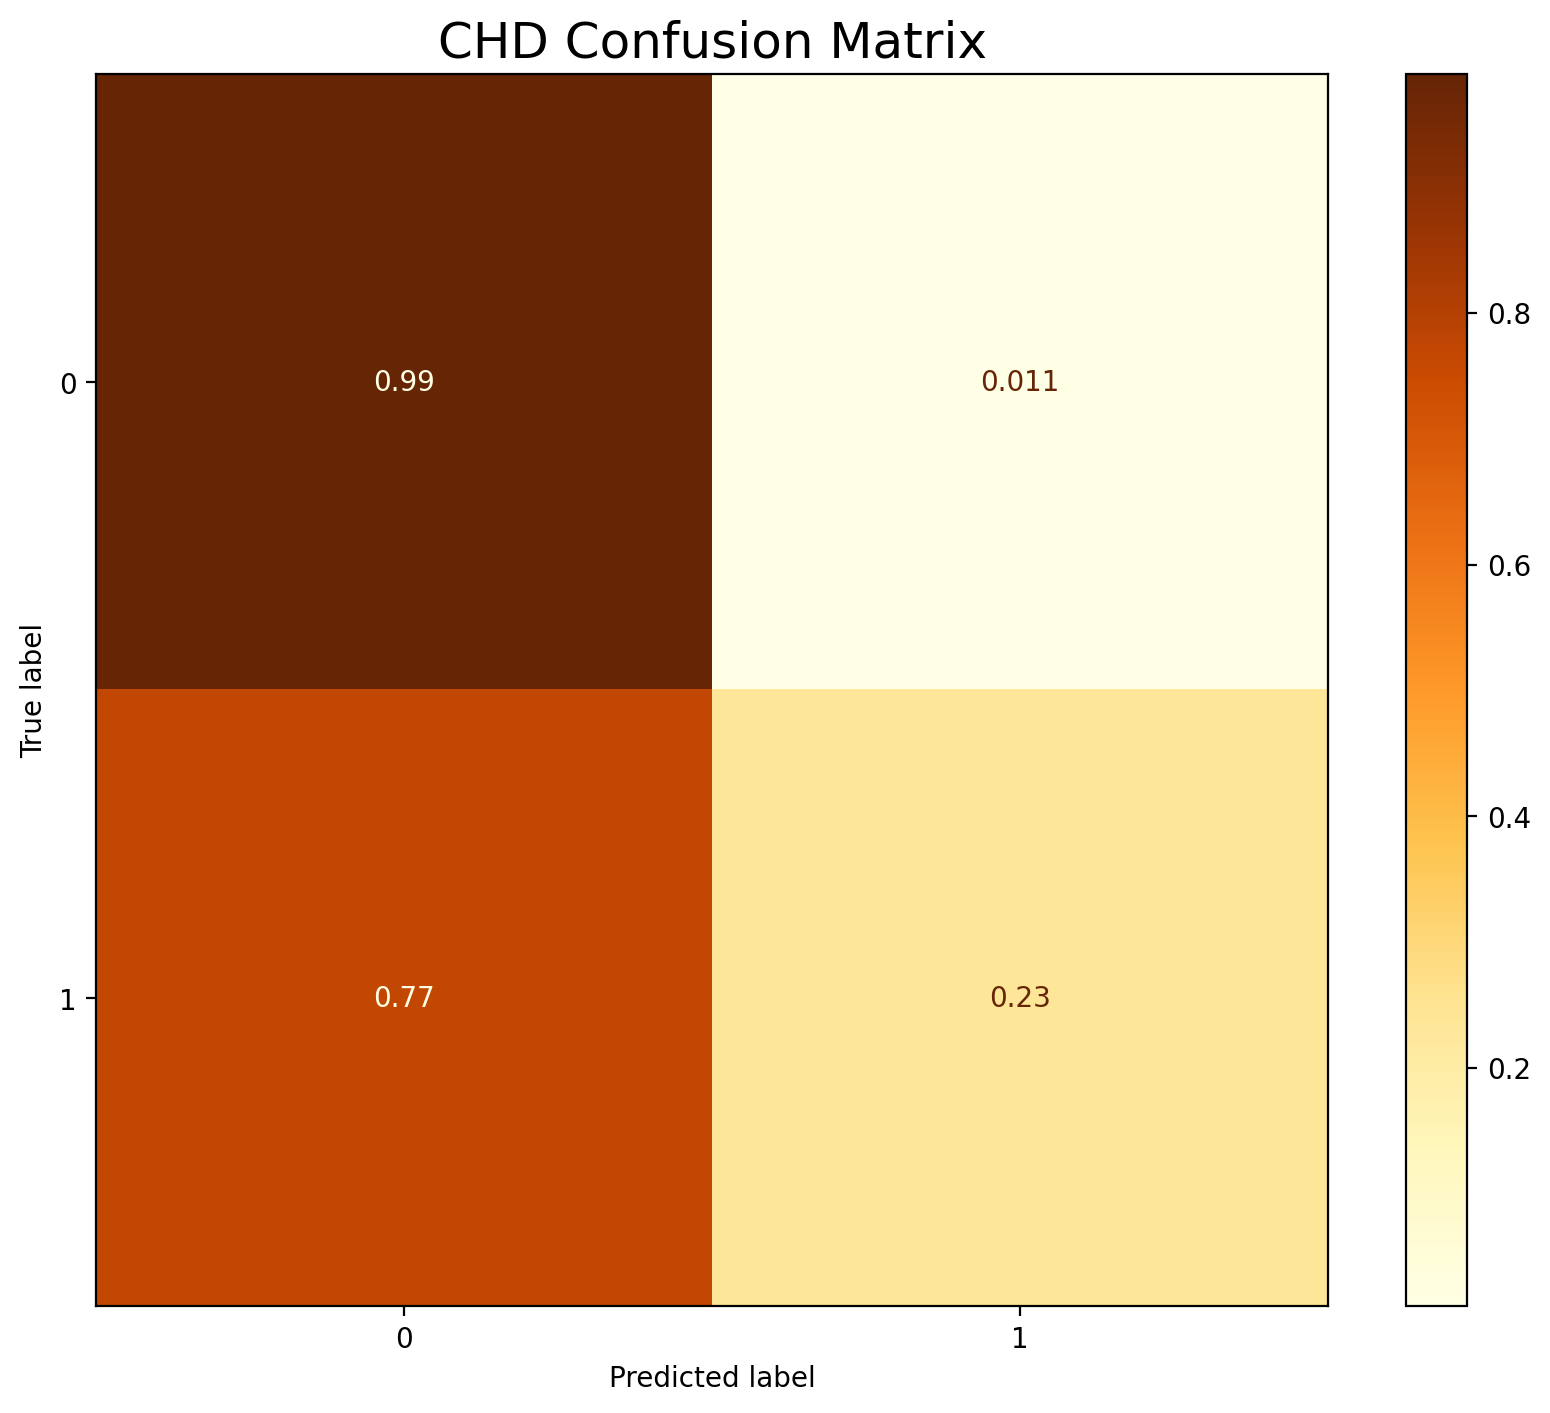

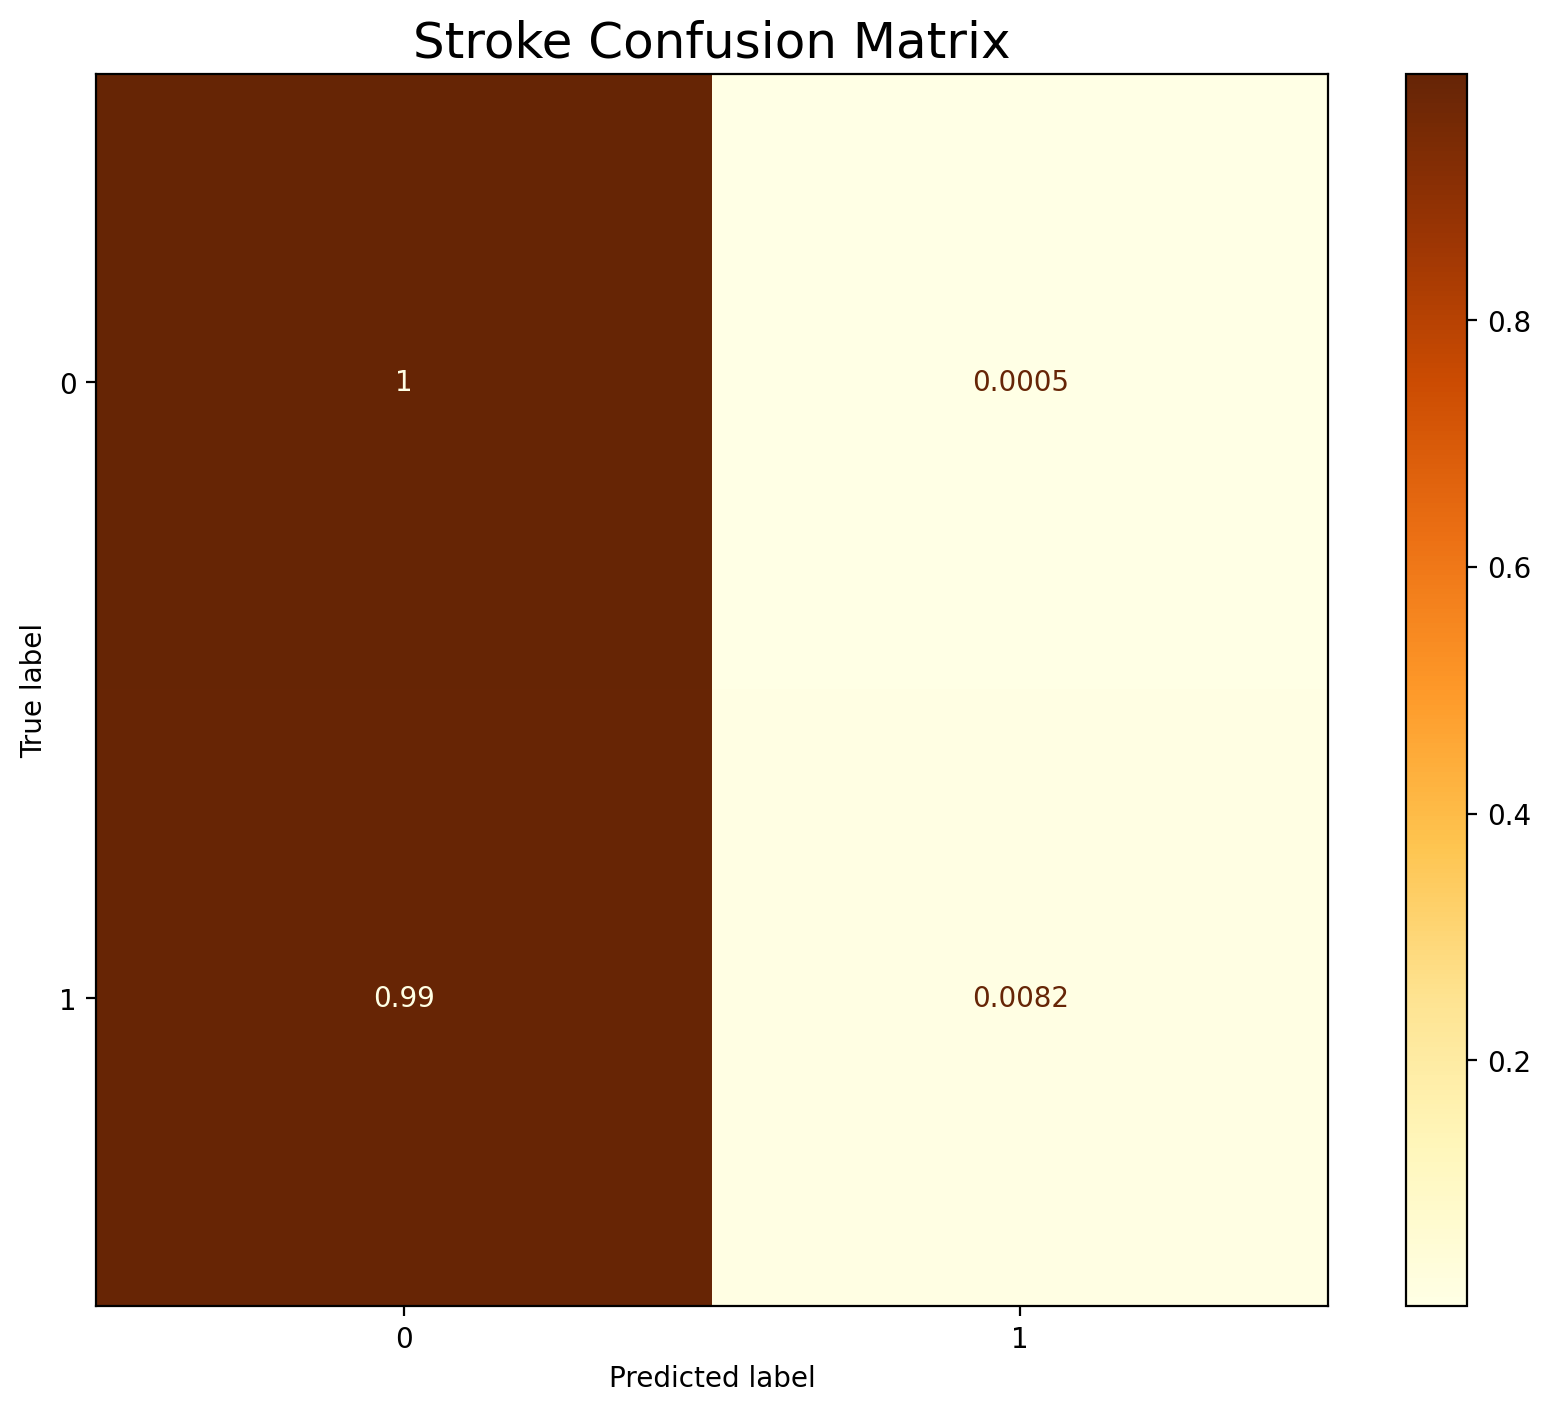

,Disease,Train Score,Test Score,Recall,Precision,Accuracy
0,HTN,0.72,0.72,57.29,67.30,71.83
1,DM,0.87,0.87,15.47,61.86,86.98
2,Asthma,0.86,0.86,5.66,60.24,85.57
3,COPD,0.92,0.92,14.72,59.33,92.33
4,Arthritis,0.72,0.72,42.55,62.83,72.25
5,Kidney_Disease,0.96,0.96,0.40,50.00,95.79
6,Depression,0.81,0.81,11.94,64.17,80.76
7,MI,0.95,0.95,21.22,54.77,94.94
8,CHD,0.95,0.95,23.31,55.54,94.83
9,Stroke,0.96,0.96,0.82,41.18,95.91


In [11]:
np.random.seed(1212)

report = pd.DataFrame(columns=['Disease', 'Train Score','Test Score','Recall','Precision','Accuracy'])

for disease in diseases:
    df_mod = df.dropna(subset=[col]).copy()
    
    for col in df_mod.columns:
        if col in num_vars:
            df_mod[col] = df_mod[col].fillna(df_mod[col].mean())
        else:
            if df_mod[col].dropna().isin(['Yes', 'No']).all() == True:
                df_mod[col] = df_mod[col].str.get_dummies()['Yes']
            else:
                df_mod[df_mod[col].dropna().unique().tolist()] = pd.get_dummies(df_mod[col])
                df_mod.drop([col], axis = 1, inplace=True)
    
    y = df_mod[disease]
    x = df_mod.drop(disease, axis=1)
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=1212)

    fit = LogisticRegression().fit(x_train, y_train)
    y_preds = fit.predict(x_test)

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_title(f"{disease} Confusion Matrix")
    metrics.plot_confusion_matrix(fit, x_test, y_test, cmap='YlOrBr', normalize='true', ax=ax)
    plt.show()
    
    train_score = round(fit.score(x_train, y_train), 2)
    test_score = round(fit.score(x_test, y_test), 2) 
    recall = round(metrics.recall_score(y_test, y_preds)*100, 2)
    precision = round(metrics.precision_score(y_test, y_preds)*100, 2)
    accuracy = round(metrics.accuracy_score(y_test, y_preds)*100, 2)

    report.loc[len(report.index)] = [str(disease), train_score, test_score, recall, precision, accuracy]

report


# Insights found in this project:<br>

- __DM:__
    - Diabetic patients who also suffer from cardiovascular complications or kidney diseases have higher probability of checking for retinopathy than those who are not.
    - Diabetic patients who also suffer from cardiovascular complications or kidney diseases have higher probability of taking insulin than those who are not.
    - Diabetic patients who take insulin for their diabetes usually get diagnosed at lower age than those who do not with an average of 8 years. This is most probably because those who are diagnosed at lower age are type-1 diabetes, but unfortunately, more data is required to prove that hypothesis.
    - Diabetic patients who take insulin on average have higher weight and BMI than those who are not.
    - On average, Diabetic patients who have insurance get diagnosed at age 8 years younger than those who do not have insurance.
    - For diabetic patients, average alcoholic drinks are the same between those who take Insulin and those who do not.
    - For diabetic patients, average blood glucose measurement is the same between those who have insurance and those who do not.
    - With each 1 increase point in BMI, the person is 1.1 times more likely to be diagnosed with Diabetes.
    - With married people, Diabetes is 0.5 times more likely to occur.
<br><br>
- __Veterans__:
    - Veterans are less likely to be diagnosed depression or Asthma, but are more likely to be diagnosed with Arthritis, COPD, Diabetes, Hypertension and cardiovascular complications.
    - Veterans tend to be diagnosed with Diabetes at considerably higher age, which could be related to better physical health of veterans.
<br><br>
- __Rural areas:__
    - Proportion of people living in rural areas who suffer from Asthma or Hypertension is around 5% higher than those who live in urban areas.
    - There is no difference in the proportion of patients having kidney disease between those who live in rural counties and urban counties.
    - For diabetic patients, average blood glucose measurement, A1C measurement, feet checking, is the same between those who live in urban areas or rural areas.
<br><br>
- __Gender:__
    - Proportion of females who are diagnosed with Arthritis, Asthma, & Depression is more than males.
    - Proportion of males who are diagnosed with cardiovascular diseases (HTN, MI, CHD) is more than females.
    - For diabetic patients, females tend to get diagnosed with Diabetes at lower age compared to men, and their average blood glucose and A1C measurement is higher.
<br><br>
- __Other Insights:__
    - In all diseases in the datasets, patients who were diagnosed had a higher average BMI than those who were not diagnosed.
    - There is no difference in the average alcohol drinks between those diagnosed with Asthma and those who are not.
    - People who are any kind of insurance were more likely to be diagnosed in all the diseases in the dataset. Most probable reason is that those who do not have insurance suffer from those disease but are undiagnosed, which would put them at risk for complications, but more data is needed to confirm this hypothesis.